In [1]:
import torch
from torch.autograd import Variable
import numpy as np
import torch.nn.functional as F
import torchvision
from torchvision import transforms
from torchvision.utils import make_grid, save_image
# from torch.utils.tensorboard import SummaryWriter

from tensorboardX import SummaryWriter
from math import log

import torch.optim as optim
from torch import nn
from torch.utils.data import TensorDataset, DataLoader, Dataset

import torch.distributions as tdists

from tqdm import tqdm

from pathlib import Path
import argparse
import os
import math

from scipy import linalg
import matplotlib.pyplot as plt
import matplotlib as mpl
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.colors import LogNorm


# plt.ioff()

import itertools
import seaborn as sns


sns.set(rc={'figure.figsize':(4,4), "lines.linewidth":2.0}, style="whitegrid", font_scale=1.2)

In [2]:

def create_dir_with_index(path):
    made = False
    counter = 1
    while made == False:
        if not os.path.exists(path):
            os.makedirs(path)
            made = True
            return path
        else:
            new_path = path + '_' + str(counter)
            if not os.path.exists(new_path):
                os.makedirs(new_path)
                made = True
                return new_path
            else:
                counter += 1


class VAE(torch.nn.Module):
    def __init__(self,
                 input_dim=1,
                 latent_dim=1,
                 post_sig=0,
                 data_sig=np.sqrt(0.1),
                 dataset_size=1000,
                 beta=1,
                 hidden_dim=256,
                 tcvae=True):
        super(VAE, self).__init__()
        self.beta=beta
        self.tcvae = tcvae
        self.latent_dim = latent_dim
        self.input_dim = input_dim
        self.post_sig = post_sig
        self._enc_mu = torch.nn.Sequential(
            torch.nn.Linear(input_dim, hidden_dim, bias=True),
            torch.nn.Sigmoid(),
            torch.nn.Linear(hidden_dim, hidden_dim, bias=True),
            torch.nn.Sigmoid(),
            torch.nn.Linear(hidden_dim, latent_dim, bias=True))
        self._dec = torch.nn.Sequential(
            torch.nn.Linear(latent_dim, hidden_dim, bias=True),
            torch.nn.Sigmoid(),
            torch.nn.Linear(hidden_dim, hidden_dim, bias=True),
            torch.nn.Sigmoid(),
            torch.nn.Linear(hidden_dim, input_dim, bias=True))
            
        if post_sig == 0:
            self._enc_log_sigma = torch.nn.Sequential(
                torch.nn.Linear(input_dim, hidden_dim, bias=True),
                torch.nn.Sigmoid(),
                torch.nn.Linear(hidden_dim, hidden_dim, bias=True),
                torch.nn.Sigmoid(),
                torch.nn.Linear(hidden_dim, latent_dim, bias=True))

        self.dim_s = latent_dim
        self.data_sig = data_sig
        self.dataset_size = dataset_size
        self.prior = tdists.Normal(torch.zeros(self.dim_s, ),torch.ones(self.dim_s,))

    def _sample_latent(self, x_in):
        """
        Return the latent normal sample z ~ N(mu, sigma^2)
        """

        self.z_loc = self._enc_mu(x_in)

        if self.post_sig == 0:
            z_log_scale = self._enc_log_sigma(x_in)
            self.z_scale = torch.exp(z_log_scale)
        else:
            self.z_scale = self.post_sig

        self.posterior = tdists.Normal(loc=self.z_loc, scale=self.z_scale)

        return self.posterior.rsample()

    def kl(self, z):
        return self.posterior.log_prob(z).sum(-1) - self.prior.log_prob(z)

    def log_prob(self, x_in):
        return self.forward(x_in)

    def forward(self, x_in):
        z = self._sample_latent(x_in)
        if self.mix_method == 'unconstrained' or self.mix_method == 'deconv':
            x_out = self._dec(z)
        likelihood_dist = torch.distributions.Normal(loc=x_out, scale=self.data_sig)
        return likelihood_dist, z
    
    def recon(self,x):
        # log p(x|z) + log p(z) - log q(z|x)
        batch_size = x.size(0)
        x = x.view(batch_size, -1)
        zs = self._enc_mu(x)
        x_out = self._dec(zs)
        return x_out
        
    
    def elbo(self, x):
        # log p(x|z) + log p(z) - log q(z|x)
        batch_size = x.size(0)
        x = x.view(batch_size, -1)
        zs = self._sample_latent(x)
        
        x_out = self._dec(zs)
        likelihood_dist = torch.distributions.Normal(loc=x_out, scale=self.data_sig)
        logpx = likelihood_dist.log_prob(x).view(batch_size, -1).sum(1)
            
        logpz = self.prior.log_prob(zs).view(batch_size, -1).sum(1)
        logqz_condx = self.posterior.log_prob(zs).view(batch_size, -1).sum(1)

        elbo = logpx + logpz - logqz_condx

        return elbo, elbo.detach()
        

def nats_to_bits_per_dim(nats, x_size):
    return nats / (log(2) * x_size)


def plot_reconstructed(vae, r0=(-1.2, 1.2), r1=(-1.2, 1.2), n=12, gap=3, w=32):
    img = list()
    for i, y in enumerate(np.linspace(*r1, n)):
        for j, x in enumerate(np.linspace(*r0, n)):
            z = torch.Tensor([[x, y]]).to(device)
            x_hat = vae._dec(z)
            x_hat = x_hat.reshape(3, w, w).to('cpu').detach().numpy()
            x_hat = np.transpose(x_hat,(1,2,0))
            img.append(x_hat[np.newaxis,:])

    img = np.concatenate(img)
    min_ = img.min()
    max_ = img.max()

    img = (img - min_)/(max_ - min_)

    return img

def add_bool_arg(parser, name, default=False):
    group = parser.add_mutually_exclusive_group(required=False)
    group.add_argument('--' + name, dest=name, action='store_true')
    group.add_argument('--no-' + name, dest=name, action='store_false')
    parser.set_defaults(**{name:default})


In [3]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import make_pipeline
from sklearn.base import BaseEstimator
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV, KFold
from numpy.polynomial.hermite_e import HermiteE




    
def compute_spectra(N, frames): 
    # Make array for heatmap
    dynamics = []
    xticks = []
    for iframe, frame in enumerate(frames): 
        # Compute fft of prediction
        frq, yfft = fft(N, frame.recon.squeeze())
        dynamics.append(yfft)
        xticks.append(frame.iter_num)
    return np.array(frq), np.array(dynamics), np.array(xticks)

def plot_spectral_dynamics(N, all_frames):
    all_dynamics = []
    K = list(range(1,11))
    # Compute spectra for all frames
    for frames in all_frames: 
        frq, dynamics, xticks = compute_spectra(N, frames)
        all_dynamics.append(dynamics)
    # Average dynamics over multiple frames
    # mean_dynamics.shape = (num_iterations, num_frequencies)
    mean_dynamics = np.array(all_dynamics).mean(0)
    # Select the frequencies which are present in the target spectrum
    freq_selected = mean_dynamics[:, np.sum(frq.reshape(-1, 1) == K, 
                                            axis=-1, dtype='bool')]
    # Normalize by the amplitude. Remember to account for the fact that the measured spectra 
    # are single-sided (positive freqs), so multiply by 2 accordingly
    norm_dynamics = 2 * freq_selected * 20
    # Plot heatmap
    plt.figure(figsize=(5, 5))
    # plt.title("Evolution of Frequency Spectrum (Increasing Amplitudes)")
    sns.heatmap(norm_dynamics[::-1], 
                xticklabels= K, 
                yticklabels=[(frame.iter_num if frame.iter_num % 10 == 0 else '') 
                             for _, frame in zip(range(norm_dynamics.shape[0]), frames)][::-1], 
                vmin=0., vmax=1., 
                cmap=sns.cubehelix_palette(8, start=.5, rot=-.75, reverse=True, as_cmap=True))
    plt.xlabel("Frequency [Hz]")
    plt.ylabel("Training Iteration")
    plt.show()


def fft(N, yt):
    n = len(yt) # length of the signal
    k = np.arange(n)
    T = n/N
    frq = k/T # two sides frequency range
    frq = frq[range(n//2)] # one side frequency range
    # -------------
    FFTYT = np.fft.fft(yt)/n # fft computing and normalization
    FFTYT = FFTYT[range(n//2)]
    fftyt = abs(FFTYT)
    return frq, fftyt

def plot_results(t, mean_curve, recon_mean=None, recon_std=None, title=''):
    fig, ax = plt.subplots()
    plt.xlabel("t")
    plt.ylabel(r'y')
    p = plt.plot(t, mean_curve, label=f'Original')
    ax.lines[0].set_linestyle("-")


    if recon_mean is not None: 
        recon_mean = recon_mean.reshape(-1)
        p = plt.plot(t, recon_mean, label=f'Recon')
        ax.lines[1].set_linestyle("-.")
#         best_Hermite_deg(t,recon_mean)
        plt.fill_between(t, recon_mean + recon_std, recon_mean - recon_std, alpha=0.15)
    plt.legend()
    plt.title(title)
    plt.show()
    fig.savefig(title + '.pdf')

/Users/camulo/miniconda3/envs/nsf/lib/python3.7/site-packages/ipykernel_launcher.py:22: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead


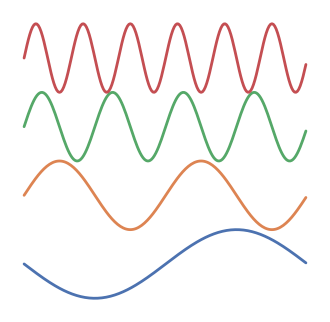

In [151]:
import numpy as np 
from matplotlib.backends.backend_agg import FigureCanvasAgg as FigureCanvas
sns.set(rc={'figure.figsize':(4,4), "lines.linewidth":2.0}, style="whitegrid", font_scale=1.2)

f = plt.figure(facecolor='white', dpi=100)
canvas = FigureCanvas(f)

plt.axis('off')

t = np.arange(-1,1,2/200)
waves = []
for i, phi in enumerate([0.5,1,2,3]):
    waves.append(np.sin(2 * np.pi * phi*t) + 2*i)
    p = plt.plot(t, waves[-1], label=f'Original')
    
plt.savefig('waves.pdf')
    
canvas.draw()
s, (width, height) = canvas.print_to_buffer()

# Option 2a: Convert to a NumPy array.
X = np.fromstring(s, np.uint8).reshape((height, width, 4))


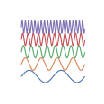

In [21]:

import matplotlib.pyplot as plt
import matplotlib.image as mpimg

def display_image_in_actual_size(im_path):

    dpi = 80
    im_data = plt.imread(im_path)
    height, width, depth = im_data.shape

    # What size does the figure need to be in inches to fit the image?
    figsize = width / float(dpi), height / float(dpi)

    # Create a figure of the right size with one axes that takes up the full figure
    fig = plt.figure(figsize=figsize)
    ax = fig.add_axes([0, 0, 1, 1])

    # Hide spines, ticks, etc.
    ax.axis('off')

    # Display the image.
    ax.imshow(im_data, cmap='gray')

    plt.show()
    
display_image_in_actual_size('waves.png')

torch.Size([200, 4])


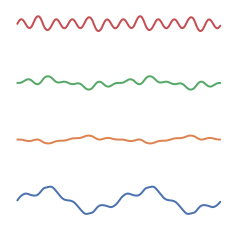

In [181]:
from argparse import Namespace

# "we can apply convs that do strides in encoder and decoder networks before or after ResNet blocks."
# False means strided convs are done before ResNet blocks
# True means, for some stride values, partially done before and partially after
args = dict()
args['batch_size'] = 200
args['post_sig'] = 1.35
args['lr'] = 0.001
args['data_sig'] = 0.1
args['latent_dim'] = 4
args['val_steps'] = 50
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
deg = 2
# make toy data

batch_size = args['batch_size']
latent_dim = args['latent_dim']
torch.manual_seed(0)
np.random.seed(0)

waves = []
t = np.arange(-2,2,4/args['batch_size'])
for i, phi in enumerate([0.5,1,2,3]):
    waves.append(np.sin(2 * np.pi * phi*t))
X = np.stack(waves,axis=1)
raw_data = X
tensor_x = torch.Tensor(raw_data) # transform to torch tensor
print(tensor_x.shape)
x_size = 1
im_width = 1

random_batch = tensor_x.to(device)

vae = VAE(latent_dim=latent_dim,
          input_dim=tensor_x.shape[1],
          dataset_size=batch_size,
          post_sig=args['post_sig'],
          beta=1)

vae.to(device)
tensor_x = tensor_x.to(device)

token = 'it'+'_'.join([str(v) for v in args.values()])
optimizer = optim.Adam(vae.parameters(), lr=args['lr'])
l = None

run_dir = Path('runs') / Path(token)
run_dir = Path(create_dir_with_index(str(run_dir)))

summary_writer = SummaryWriter(run_dir, max_queue=100)

frames = []
num_steps = 250
vae.train()
for i in range(num_steps):
    step = i
    # inputs = Variable(inputs.resize_(batch_size, input_dim))
    optimizer.zero_grad()
    elbo = vae.elbo(tensor_x)
    loss = -elbo[0].sum(-1).mean()
    loss.backward(retain_graph=True)
    optimizer.step()
    l = loss.data
    if i % args['val_steps'] == 0:
        # plot q(z|x) means and samples in z
        with torch.no_grad():
            summary_writer.add_scalar('loss/loss', loss.item(), step)
        frames.append(Namespace(iter_num = step, recon=vae.recon(tensor_x).detach().numpy()))

recon = vae.recon(tensor_x).detach().numpy()

for i, phi in enumerate([0.5,1,2,3]):
    p = plt.plot(t, recon[:,i] + 2*i)
plt.axis('off')

plt.savefig('waves1.pdf')
vae1 = vae  


In [47]:
from PIL import Image
import numpy as np

recon_copy = recon.copy()
recon_copy 

img = Image.fromarray(tensor_x.detach().numpy().reshape(X.shape), 'RGB')
img.show()

/Users/camulo/miniconda3/envs/nsf/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/Users/camulo/miniconda3/envs/nsf/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/Users/camulo/miniconda3/envs/nsf/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or mis

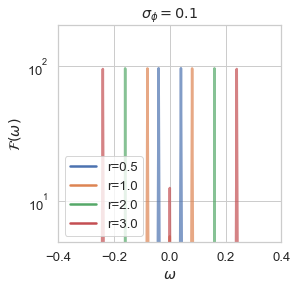

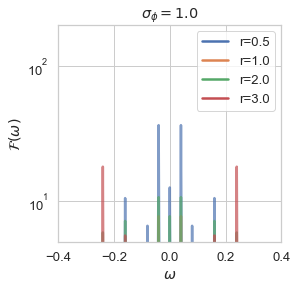

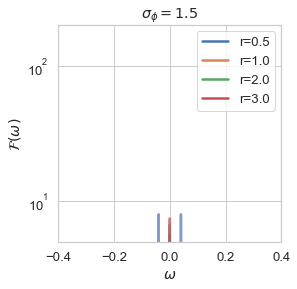

In [198]:
import matplotlib.pyplot as plt
import numpy as np

sns.set(rc={'figure.figsize':(4,4), "lines.linewidth":2.5}, style="whitegrid", font_scale=1.2)


# f.savefig('fftsinc.pdf', bbox_inches='tight')

f, ax = plt.subplots()
recon = vae01.recon(tensor_x).detach().numpy()
for i, phi in enumerate([0.5,1,2,3]):
    y_fft = np.fft.fftshift(np.abs(np.fft.fft(recon[:,i])))
    # plt.plot(x,y)
    sns.lineplot(t,y_fft, label='r=%.1f'%(phi))
ax.set(xlim=[-0.4,0.4],ylim=[5,200], xlabel='$\omega$', ylabel='$\mathcal{F} (\omega)$', title='$\sigma_\phi=0.1$')
ax.set_yscale('log')
for line in ax.lines:
    line.set_alpha(0.7)
plt.savefig('wavesfft01.pdf')


f, ax = plt.subplots()
recon = vae1.recon(tensor_x).detach().numpy()
for i, phi in enumerate([0.5,1,2,3]):
    y_fft = np.fft.fftshift(np.abs(np.fft.fft(recon[:,i])))
    # plt.plot(x,y)
    sns.lineplot(t,y_fft, label='r=%.1f'%(phi))
ax.set(xlim=[-0.4,0.4],ylim=[5,200], xlabel='$\omega$', ylabel='$\mathcal{F} (\omega)$', title='$\sigma_\phi=1.0$')
ax.set_yscale('log')
for line in ax.lines:
    line.set_alpha(0.7)
plt.savefig('wavesfft1.pdf')


f, ax = plt.subplots()
recon = vae15.recon(tensor_x).detach().numpy()
for i, phi in enumerate([0.5,1,2,3]):
    y_fft = np.fft.fftshift(np.abs(np.fft.fft(recon[:,i])))
    # plt.plot(x,y)
    sns.lineplot(t,y_fft, label='r=%.1f'%(phi))
ax.set(xlim=[-0.4,0.4],ylim=[5,200], xlabel='$\omega$', ylabel='$\mathcal{F} (\omega)$', title='$\sigma_\phi=1.5$')
ax.set_yscale('log')
plt.savefig('wavesfft15.pdf')


for line in ax.lines:
    line.set_alpha(0.7)





# ax.legend(loc='upper center', bbox_to_anchor=(0.5, 1.25),
#           ncol=2, fancybox=True, shadow=True)

plt.show()



In [163]:
! mkdir -p saved_weights/v1

In [169]:
from scipy.io import savemat

for name, v in zip(['v01','v05','v1'], [vae01,vae05,vae1]): 
    fname = os.path.join(os.getcwd(), 'saved_weights/'+name+'/dec_weights.mat')
    weights = [v._dec[0].weight.data.numpy().astype(np.float64), 
               v._dec[2].weight.data.numpy().astype(np.float64), 
               v._dec[4].weight.data.numpy().astype(np.float64)]
    data = {'weights': np.array(weights, dtype=np.object)}
    savemat(fname, data)
    
for name, v in zip(['v01','v05','v1'], [vae01,vae05,vae1]): 
    fname = os.path.join(os.getcwd(), 'saved_weights/'+name+'/enc_mu_weights.mat')
    weights = [v._enc_mu[0].weight.data.numpy().astype(np.float64), 
               v._enc_mu[2].weight.data.numpy().astype(np.float64), 
               v._enc_mu[4].weight.data.numpy().astype(np.float64)]
    data = {'weights': np.array(weights, dtype=np.object)}
    savemat(fname, data)

    

In [165]:
print(vae05._dec[0].weight.data.numpy().astype(np.float64))

[[ 0.09739525]
 [ 0.09178988]
 [ 0.77777171]
 [-0.01284883]
 [ 0.09585975]
 [-0.03867243]
 [ 0.93211609]
 [-1.03179443]
 [ 0.36557034]
 [-0.57248437]
 [ 0.09943556]
 [ 0.66826171]
 [ 0.64399463]
 [ 0.50604939]
 [ 0.31446701]
 [ 0.69998556]
 [ 1.00212467]
 [ 0.96933734]
 [-0.1955848 ]
 [-0.84381562]
 [-0.13607146]
 [ 0.86188853]
 [ 0.63369215]
 [-0.75384611]
 [ 0.35200819]
 [-0.42505512]
 [ 0.83441162]
 [ 0.98429787]
 [-0.5482831 ]
 [-0.37162507]
 [-0.32114738]
 [ 0.39645913]
 [ 0.71227378]
 [-0.26917753]
 [-0.1582787 ]
 [ 0.14526026]
 [ 0.37454864]
 [ 0.30325842]
 [ 0.60930371]
 [ 0.65262324]
 [ 0.30458018]
 [-0.5297004 ]
 [ 0.09016943]
 [-0.60150576]
 [ 0.44408655]
 [ 0.90128171]
 [ 0.41585332]
 [ 0.48409981]
 [-0.76818568]
 [ 0.67514569]
 [-0.55408061]
 [ 0.28347495]
 [ 0.52802694]
 [ 0.7084235 ]
 [-0.09160323]
 [-0.42913771]
 [ 0.77323335]
 [-0.49947435]
 [ 0.65381521]
 [ 0.95321572]
 [-0.04186051]
 [ 0.28989145]
 [ 0.81142002]
 [-0.44060597]
 [ 0.16316493]
 [-0.94432116]
 [-0.32497